### BNB with Tensor Parallelism

In [1]:
import torch
import copy
from bitsandbytes.nn.modules import Params4bit, Linear4bit
from bitsandbytes.functional import dequantize_4bit
import bitsandbytes as bnb
from bitsandbytes.functional import dequantize_4bit, QuantState

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig

In [3]:
blocksize = 64
quant_type = "nf4"
quant_storage = torch.uint8

data = torch.randn(128,256).to(torch.bfloat16)
param = Params4bit(data, blocksize=blocksize, quant_type=quant_type, 
                   quant_storage=quant_storage, compress_statistics=False)

In [4]:
if quant_storage == torch.uint8:
    pack_factor = 2

In [5]:
param

Parameter containing:
Parameter(Params4bit([[-0.1260, -1.6250,  0.0508,  ...,  0.3379, -1.7500,  1.1484],
            [-0.2305, -1.3047, -2.0312,  ..., -0.1328, -0.3125,  1.8594],
            [-1.1875,  0.9766,  0.0840,  ..., -2.2812,  0.6016,  1.1328],
            ...,
            [ 1.1875,  1.0234,  1.3281,  ...,  1.5781, -0.7227,  0.5156],
            [ 0.0610, -0.3477,  1.2578,  ..., -1.7109,  1.0781,  0.6914],
            [ 0.2002, -0.7422,  0.0527,  ...,  1.1953, -0.0952,  0.0854]],
           dtype=torch.bfloat16))

In [6]:
param.cuda();

In [7]:
param.shape, param.quant_type, param.quant_storage, param.blocksize

(torch.Size([16384, 1]), 'nf4', torch.uint8, 64)

In [8]:
param.shape

torch.Size([16384, 1])

In [9]:
param.numel() / data.numel()

0.5

In [10]:
param.quant_state.as_dict()

{'quant_type': 'nf4',
 'absmax': tensor([2.6406, 2.4062, 3.7812, 2.2344, 2.7500, 3.2500, 2.2500, 2.8594, 2.7656,
         2.4688, 3.2969, 3.4844, 2.7812, 2.2188, 2.9375, 3.2812, 2.1094, 2.8125,
         2.2344, 3.2344, 3.2188, 2.8125, 2.3906, 2.2812, 2.7031, 3.5938, 2.5156,
         2.9219, 2.1875, 3.0469, 2.5781, 2.5781, 2.2188, 2.8125, 2.3281, 2.6094,
         2.9219, 2.7344, 2.1719, 3.4375, 2.5000, 3.0625, 2.4688, 2.5625, 2.9531,
         2.8125, 2.7969, 2.2500, 3.6094, 2.4062, 2.0781, 2.4531, 3.3281, 2.6250,
         3.1250, 2.7969, 2.8594, 2.4844, 2.8906, 2.5000, 2.1719, 3.1406, 2.6094,
         2.4375, 3.0000, 2.2188, 3.4062, 3.9688, 2.6250, 2.5938, 2.2500, 3.0000,
         2.7188, 2.5625, 2.5156, 3.3750, 2.5469, 2.8125, 3.0781, 2.4688, 2.5781,
         3.3281, 2.5781, 1.7109, 2.9375, 2.0781, 2.2031, 2.3750, 2.0312, 2.3750,
         2.4688, 2.6406, 2.2812, 2.2344, 3.2031, 2.5312, 1.8203, 2.3438, 2.0625,
         2.7500, 2.5312, 2.6094, 2.4844, 2.7188, 2.6562, 2.1094, 1.8594, 2.46

In [11]:
input_size_per_partition = 64
output_size_per_partition = 64

In [12]:
# row-major quantization, reshape for vllm tensor parallelism
qweight = param.data.reshape(data.size(0), data.size(1) // pack_factor); qweight.shape

torch.Size([128, 128])

In [13]:
qweight

tensor([[ 97, 119,  55,  ...,  65, 201,  29],
        [ 98,  24,  97,  ..., 156, 134, 110],
        [ 59, 112,  71,  ...,  58,  81, 155],
        ...,
        [203, 201, 227,  ...,  20, 173,  73],
        [117, 217, 181,  ...,  65,  97, 202],
        [132, 122, 134,  ...,  38,  44, 119]], device='cuda:0',
       dtype=torch.uint8)

In [14]:
qweight.view(-1,1)

tensor([[ 97],
        [119],
        [ 55],
        ...,
        [ 38],
        [ 44],
        [119]], device='cuda:0', dtype=torch.uint8)

In [15]:
deqweight = dequantize_4bit(qweight.view(-1,1), param.quant_state, blocksize=blocksize)

In [16]:
(data - torch.randn_like(data)).norm()

tensor(254., dtype=torch.bfloat16)

In [17]:
(data - deqweight.cpu()).norm()

tensor(16.5000, dtype=torch.bfloat16)

In [18]:
x = torch.randn(4, 128).cuda().to(torch.bfloat16)

In [19]:
param.quant_state.as_dict()

{'quant_type': 'nf4',
 'absmax': tensor([2.6406, 2.4062, 3.7812, 2.2344, 2.7500, 3.2500, 2.2500, 2.8594, 2.7656,
         2.4688, 3.2969, 3.4844, 2.7812, 2.2188, 2.9375, 3.2812, 2.1094, 2.8125,
         2.2344, 3.2344, 3.2188, 2.8125, 2.3906, 2.2812, 2.7031, 3.5938, 2.5156,
         2.9219, 2.1875, 3.0469, 2.5781, 2.5781, 2.2188, 2.8125, 2.3281, 2.6094,
         2.9219, 2.7344, 2.1719, 3.4375, 2.5000, 3.0625, 2.4688, 2.5625, 2.9531,
         2.8125, 2.7969, 2.2500, 3.6094, 2.4062, 2.0781, 2.4531, 3.3281, 2.6250,
         3.1250, 2.7969, 2.8594, 2.4844, 2.8906, 2.5000, 2.1719, 3.1406, 2.6094,
         2.4375, 3.0000, 2.2188, 3.4062, 3.9688, 2.6250, 2.5938, 2.2500, 3.0000,
         2.7188, 2.5625, 2.5156, 3.3750, 2.5469, 2.8125, 3.0781, 2.4688, 2.5781,
         3.3281, 2.5781, 1.7109, 2.9375, 2.0781, 2.2031, 2.3750, 2.0312, 2.3750,
         2.4688, 2.6406, 2.2812, 2.2344, 3.2031, 2.5312, 1.8203, 2.3438, 2.0625,
         2.7500, 2.5312, 2.6094, 2.4844, 2.7188, 2.6562, 2.1094, 1.8594, 2.46

In [29]:
input_size, output_size = data.size()

In [34]:
input_size, output_size

(128, 256)

### Column Parallel

The linear layer is defined as Y = XA + b. A is parallelized along its second dimension as A = [A_1, ..., A_p].

In [37]:
num_partitions = 2

In [20]:
qweight.shape

torch.Size([128, 128])

In [21]:
output_size_per_partition

64

In [22]:
qweight_partitioned = qweight.split(output_size_per_partition, dim=1)

In [23]:
len(qweight_partitioned)

2

In [24]:
for w in qweight_partitioned: print(w.shape)

torch.Size([128, 64])
torch.Size([128, 64])


In [25]:
orig_absmax = param.quant_state.absmax

In [26]:
orig_absmax.shape

torch.Size([512])

In [31]:
orig_absmax_reshaped = orig_absmax.reshape(input_size, data.size(1) // blocksize)

In [33]:
orig_absmax_reshaped.dtype, orig_absmax_reshaped.shape

(torch.float32, torch.Size([128, 4]))

In [91]:
num_partitions = len(qweight_partitioned)

In [38]:
absmax_partitioned = orig_absmax_reshaped.split(orig_absmax_reshaped.size(1) // num_partitions, dim=1)

In [39]:
for a in absmax_partitioned: print(a.shape)

torch.Size([128, 2])
torch.Size([128, 2])


In [40]:
len(qweight_partitioned), len(absmax_partitioned)

(2, 2)

In [41]:
quant_state = copy.deepcopy(param.quant_state)

In [42]:
quant_state.shape = torch.Size([quant_state.shape[0], quant_state.shape[1]//num_partitions])

In [43]:
quant_state.shape

torch.Size([128, 128])

In [44]:
quant_state.absmax = absmax_partitioned[0].contiguous().view(-1)
deqweight_part1 = dequantize_4bit(qweight_partitioned[0].contiguous().view(-1,1), quant_state=quant_state)

quant_state.absmax = absmax_partitioned[1].contiguous().view(-1)
deqweight_part2 = dequantize_4bit(qweight_partitioned[1].contiguous().view(-1,1), quant_state=quant_state)

In [45]:
deqweight_part1.shape, deqweight_part2.shape

(torch.Size([128, 128]), torch.Size([128, 128]))

In [46]:
# quant_state.as_dict()

In [47]:
deqweight.shape

torch.Size([128, 256])

In [48]:
torch.cat([deqweight_part1, deqweight_part2], dim=1).shape

torch.Size([128, 256])

In [49]:
assert torch.equal(deqweight, torch.cat([deqweight_part1, deqweight_part2], dim=1))

In [50]:
out1 = (x @ deqweight_part2)

In [51]:
out2 = bnb.matmul_4bit(x, qweight_partitioned[1].contiguous().view(-1,1), quant_state=quant_state)

In [52]:
assert torch.equal(out1, out2)

In [53]:
out2.shape

torch.Size([4, 128])

### Row Parallel

The linear layer is defined as Y = XA + b. A is parallelized along
its first dimension and X along its second dimension as:

```
    -   -
    | A_1 |
    | .   |
A = | .   |        X = [X_1, ..., X_p]
    | .   |
    | A_p |
    -   -
```

In [54]:
qweight_partitioned = qweight.split(output_size_per_partition, dim=0)

In [55]:
num_partitions = len(qweight_partitioned); num_partitions

2

In [56]:
for w in qweight_partitioned: print(w.shape)

torch.Size([64, 128])
torch.Size([64, 128])


In [57]:
orig_absmax = param.quant_state.absmax

In [58]:
orig_absmax_reshaped = orig_absmax.reshape(input_size, data.size(1) // blocksize)

In [59]:
absmax_partitioned = orig_absmax.split(len(orig_absmax) // num_partitions, dim=0)

In [60]:
len(absmax_partitioned)

2

In [61]:
quant_state = copy.deepcopy(param.quant_state)

In [62]:
quant_state.shape = torch.Size([quant_state.shape[0]//num_partitions, quant_state.shape[1]]); quant_state.shape

torch.Size([64, 256])

In [63]:
quant_state.absmax = absmax_partitioned[0].contiguous().view(-1)
deqweight_part1 = dequantize_4bit(qweight_partitioned[0].contiguous().view(-1,1), quant_state=quant_state)

quant_state.absmax = absmax_partitioned[1].contiguous().view(-1)
deqweight_part2 = dequantize_4bit(qweight_partitioned[1].contiguous().view(-1,1), quant_state=quant_state)

In [64]:
assert torch.equal(deqweight, torch.cat([deqweight_part1, deqweight_part2], dim=0))

### Loading

In [3]:
from vllm.model_executor.weight_utils import default_weight_loader, hf_model_weights_iterator

INFO 03-29 13:23:10 pynccl_utils.py:13] vLLM is using nccl==2.18.1


In [2]:
weights_iterator = hf_model_weights_iterator("meta-llama/Llama-2-7b-hf")

In [3]:
for name, loaded_weight in weights_iterator: break

INFO 03-29 08:48:45 weight_utils.py:177] Using model weights format ['*.safetensors']


model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

In [5]:
name, loaded_weight

('model.embed_tokens.weight',
 tensor([[ 1.2517e-06, -1.7881e-06, -4.3511e-06,  ...,  8.9407e-07,
          -6.5565e-06,  8.9407e-07],
         [ 1.8616e-03, -3.3722e-03,  3.9864e-04,  ..., -8.3008e-03,
           2.5787e-03, -3.9368e-03],
         [ 1.0986e-02,  9.8877e-03, -5.0964e-03,  ...,  2.5177e-03,
           7.7057e-04, -5.0049e-03],
         ...,
         [-1.3977e-02, -2.7313e-03, -1.9897e-02,  ..., -1.0437e-02,
           9.5825e-03, -1.8005e-03],
         [-1.0742e-02,  9.3384e-03,  1.2939e-02,  ..., -3.3203e-02,
          -1.6357e-02,  3.3875e-03],
         [-8.3008e-03, -4.0588e-03, -1.1063e-03,  ...,  3.4790e-03,
          -1.2939e-02,  3.1948e-05]], dtype=torch.float16))

In [29]:
weights_iterator = hf_model_weights_iterator("TheBloke/CodeUp-Alpha-13B-HF-AWQ")

In [32]:
for name, loaded_weight in weights_iterator: 
    if 'scales' in name or 'zeros' in name:
        print(name)

model.layers.0.mlp.down_proj.qzeros
model.layers.0.mlp.down_proj.scales
model.layers.0.mlp.gate_proj.qzeros
model.layers.0.mlp.gate_proj.scales
model.layers.0.mlp.up_proj.qzeros
model.layers.0.mlp.up_proj.scales
model.layers.0.self_attn.k_proj.qzeros
model.layers.0.self_attn.k_proj.scales
model.layers.0.self_attn.o_proj.qzeros
model.layers.0.self_attn.o_proj.scales
model.layers.0.self_attn.q_proj.qzeros
model.layers.0.self_attn.q_proj.scales
model.layers.0.self_attn.v_proj.qzeros
model.layers.0.self_attn.v_proj.scales
model.layers.1.mlp.down_proj.qzeros
model.layers.1.mlp.down_proj.scales
model.layers.1.mlp.gate_proj.qzeros
model.layers.1.mlp.gate_proj.scales
model.layers.1.mlp.up_proj.qzeros
model.layers.1.mlp.up_proj.scales
model.layers.1.self_attn.k_proj.qzeros
model.layers.1.self_attn.k_proj.scales
model.layers.1.self_attn.o_proj.qzeros
model.layers.1.self_attn.o_proj.scales
model.layers.1.self_attn.q_proj.qzeros
model.layers.1.self_attn.q_proj.scales
model.layers.1.self_attn.v_pro

### Create Quantized Model Files

In [16]:
from pathlib import Path
import os, json
from safetensors.torch import save_file
import copy
from tqdm import tqdm

In [18]:
model_dir = Path("/home/ubuntu/models/llama-7b-orca-math-100k-full-quantized")
os.makedirs(model_dir, exist_ok=True)

In [ ]:
# original quantized layers from fsdp_qlora/train.py
# ["k_proj", "q_proj", "v_proj", "up_proj", "down_proj", "gate_proj"]

In [15]:
# Similar to AWQ for now
quantized_layers = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]

In [8]:
orca_math_model_dir = "/home/ubuntu/models/llama-7b-orca-math-100k-full"

In [9]:
weights = safetensors.torch.load_file(glob(os.path.join(orca_math_model_dir, "*.safetensors"))[0])

In [12]:
quantized_state_dict = copy.deepcopy(weights)

In [13]:
pack_factor = 2
blocksize = 64

In [17]:
for n,p in iter(weights.items()):
    if any(l in n for l in quantized_layers) and "weight" in n:
        # output_size x input_size
        print(n, p.shape, p.t().shape)
        param = Params4bit(p.t(), quant_type="nf4", blocksize=blocksize, compress_statistics=False, quant_storage=torch.uint8)
        input_size, output_size = p.t().shape
        param.cuda();

        # reshape for tensor parallelism
        qweight, absmax = param.data.cpu(), param.quant_state.absmax.cpu()        
        qweight = qweight.reshape(input_size, output_size // pack_factor)
        absmax = absmax.reshape(input_size, output_size // blocksize)
                
        quantized_state_dict[n] = qweight
        quantized_state_dict[n.replace(".weight", ".absmax")] = absmax

        param = None
        torch.cuda.empty_cache()

0it [00:00, ?it/s]

model.layers.0.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


4it [00:00, 12.08it/s]

model.layers.0.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.0.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


9it [00:00, 10.55it/s]

model.layers.0.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.0.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.0.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


11it [00:01, 11.27it/s]

model.layers.0.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.1.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


13it [00:01, 10.84it/s]

model.layers.1.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.1.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


18it [00:01, 10.43it/s]

model.layers.1.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.1.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.1.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


20it [00:01, 10.97it/s]

model.layers.1.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.10.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


22it [00:02, 10.72it/s]

model.layers.10.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


24it [00:02,  7.96it/s]

model.layers.10.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.10.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


27it [00:02, 10.31it/s]

model.layers.10.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.10.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.10.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


29it [00:02, 10.98it/s]

model.layers.11.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


31it [00:03, 10.62it/s]

model.layers.11.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.11.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


36it [00:03, 10.50it/s]

model.layers.11.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.11.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.11.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


38it [00:03, 11.08it/s]

model.layers.11.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.12.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


40it [00:03, 10.75it/s]

model.layers.12.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.12.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


45it [00:04, 10.53it/s]

model.layers.12.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.12.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.12.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


47it [00:04, 11.13it/s]

model.layers.12.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.13.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


49it [00:04, 10.85it/s]

model.layers.13.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.13.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


54it [00:05, 10.58it/s]

model.layers.13.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.13.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.13.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


56it [00:05, 11.21it/s]

model.layers.13.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.14.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


58it [00:05, 10.81it/s]

model.layers.14.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.14.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


63it [00:06, 10.61it/s]

model.layers.14.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.14.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.14.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


65it [00:06, 11.18it/s]

model.layers.14.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.15.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


67it [00:06, 10.87it/s]

model.layers.15.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.15.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


72it [00:07, 10.58it/s]

model.layers.15.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.15.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.15.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


74it [00:07, 11.20it/s]

model.layers.15.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.16.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


76it [00:07, 10.88it/s]

model.layers.16.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.16.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


81it [00:08, 10.56it/s]

model.layers.16.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.16.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.16.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


83it [00:08, 11.16it/s]

model.layers.16.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.17.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


85it [00:08, 10.87it/s]

model.layers.17.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.17.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


90it [00:08, 10.62it/s]

model.layers.17.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.17.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.17.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


92it [00:09, 11.05it/s]

model.layers.17.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.18.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


94it [00:09, 10.79it/s]

model.layers.18.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.18.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


99it [00:09, 10.68it/s]

model.layers.18.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.18.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.18.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


101it [00:09, 11.27it/s]

model.layers.18.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.19.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


103it [00:10, 10.97it/s]

model.layers.19.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.19.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


108it [00:10, 10.51it/s]

model.layers.19.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.19.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.19.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


110it [00:10, 11.16it/s]

model.layers.19.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.2.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


112it [00:11, 10.90it/s]

model.layers.2.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


114it [00:11,  8.05it/s]

model.layers.2.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.2.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


117it [00:11, 10.37it/s]

model.layers.2.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.2.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.2.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


121it [00:11, 10.85it/s]

model.layers.20.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])
model.layers.20.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.20.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


126it [00:12, 10.52it/s]

model.layers.20.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.20.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.20.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


128it [00:12, 11.19it/s]

model.layers.20.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.21.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


130it [00:12, 10.94it/s]

model.layers.21.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.21.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


135it [00:13, 10.68it/s]

model.layers.21.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.21.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.21.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


137it [00:13, 11.22it/s]

model.layers.21.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.22.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


139it [00:13, 10.95it/s]

model.layers.22.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.22.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


144it [00:14, 10.42it/s]

model.layers.22.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.22.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.22.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


146it [00:14, 11.08it/s]

model.layers.22.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.23.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


148it [00:14, 10.84it/s]

model.layers.23.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.23.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


153it [00:15, 10.50it/s]

model.layers.23.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.23.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.23.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


155it [00:15, 11.13it/s]

model.layers.23.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.24.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


157it [00:15, 10.85it/s]

model.layers.24.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.24.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


162it [00:16, 10.40it/s]

model.layers.24.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.24.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.24.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


164it [00:16, 11.06it/s]

model.layers.24.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.25.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


166it [00:16, 10.76it/s]

model.layers.25.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.25.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


171it [00:17, 10.55it/s]

model.layers.25.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.25.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.25.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


173it [00:17, 11.16it/s]

model.layers.25.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.26.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


175it [00:17, 10.49it/s]

model.layers.26.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.26.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


180it [00:17, 10.58it/s]

model.layers.26.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.26.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.26.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


182it [00:18, 11.25it/s]

model.layers.26.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.27.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


184it [00:18, 10.97it/s]

model.layers.27.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


186it [00:18,  8.21it/s]

model.layers.27.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.27.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


189it [00:18, 10.58it/s]

model.layers.27.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.27.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.27.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


193it [00:19, 10.87it/s]

model.layers.28.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])
model.layers.28.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


195it [00:19,  8.30it/s]

model.layers.28.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.28.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


198it [00:19, 10.66it/s]

model.layers.28.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.28.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.28.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


202it [00:20, 10.87it/s]

model.layers.29.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])
model.layers.29.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.29.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


207it [00:20, 10.71it/s]

model.layers.29.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.29.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.29.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


209it [00:20, 11.38it/s]

model.layers.29.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.3.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


211it [00:20, 10.73it/s]

model.layers.3.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.3.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


216it [00:21, 10.70it/s]

model.layers.3.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.3.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.3.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


218it [00:21, 11.19it/s]

model.layers.3.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.30.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


220it [00:21, 10.98it/s]

model.layers.30.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.30.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


225it [00:22, 10.55it/s]

model.layers.30.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.30.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.30.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


227it [00:22, 11.15it/s]

model.layers.30.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.31.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


229it [00:22, 10.95it/s]

model.layers.31.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.31.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


234it [00:23, 10.76it/s]

model.layers.31.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.31.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.31.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


236it [00:23, 11.39it/s]

model.layers.31.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.4.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


238it [00:23, 11.13it/s]

model.layers.4.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.4.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


243it [00:24, 10.90it/s]

model.layers.4.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.4.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.4.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


245it [00:24, 11.48it/s]

model.layers.4.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.5.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


247it [00:24, 11.13it/s]

model.layers.5.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


249it [00:24,  8.19it/s]

model.layers.5.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.5.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


252it [00:24, 10.59it/s]

model.layers.5.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.5.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.5.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


256it [00:25, 11.05it/s]

model.layers.6.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])
model.layers.6.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.6.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


261it [00:25, 10.78it/s]

model.layers.6.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.6.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.6.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


263it [00:25, 11.43it/s]

model.layers.6.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.7.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


265it [00:26, 11.16it/s]

model.layers.7.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.7.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


270it [00:26, 10.86it/s]

model.layers.7.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.7.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.7.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


272it [00:26, 11.40it/s]

model.layers.7.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.8.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


274it [00:27, 11.15it/s]

model.layers.8.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.8.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


279it [00:27, 10.90it/s]

model.layers.8.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.8.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.8.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


281it [00:27, 11.56it/s]

model.layers.8.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.9.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([11008, 4096])


283it [00:27, 10.91it/s]

model.layers.9.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])
model.layers.9.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([4096, 11008])


288it [00:28, 10.91it/s]

model.layers.9.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.9.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])
model.layers.9.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


291it [00:28, 10.17it/s]

model.layers.9.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([4096, 4096])


In [19]:
# save quantized weights
save_file(quantized_state_dict, model_dir/"model_state_dict.safetensors")

In [20]:
# create and save quantization config
quant_config_filename = model_dir/"quantize_config.json"

In [21]:
quant_config_dict = {
    "weight_bits" : 4,
    "blocksize" : 64,
    "quant_type" : "nf4",
    "quant_storage" : "uint8",
    "compress_statistics" : False
}

In [22]:
with open(quant_config_filename, "w+") as f: json.dump(quant_config_dict, f)

In [23]:
model_config = AutoConfig.from_pretrained("meta-llama/Llama-2-7b-hf")

In [24]:
# save model config
model_config_filename = model_dir/"config.json"

In [25]:
with open(model_config_filename, "w+") as f: json.dump(model_config.to_dict(), f)

### BNB Quantized VLLM

In [ ]:
# from huggingface_hub import hf_hub_download
# import os
# os.makedirs("/home/ubuntu/models/llama-7b-orca-math-100k-full", exist_ok=True)
# hf_hub_download(repo_id="answerdotai/llama-7b-orca-math-100k-full", 
#                 filename="model_state_dict.safetensors",
#                 local_dir="/home/ubuntu/models/llama-7b-orca-math-100k-full")

In [1]:
import torch
import torch.nn as nn
from typing import List
import safetensors
import safetensors.torch
from pathlib import Path
import bitsandbytes as bnb
from bitsandbytes.functional import dequantize_4bit, QuantState
from bitsandbytes.nn.modules import Params4bit, Linear4bit
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
from transformers.generation.configuration_utils import GenerationConfig
from accelerate import init_empty_weights
from glob import glob
import os
from fastcore.parallel import parallel

In [2]:
# !pip install accelerate

In [3]:
from vllm import LLM, SamplingParams

In [4]:
input = """###Question:
A certain tax rate is some amount per $100.00. The rate, expressed as a percent, is 65%. What is the tax rate in dollars per $100.00?
###Answer:"""

In [5]:
def replace_linear(model:nn.Module, linear_replacement:nn.Module, quant_config:dict|None=None,
                   skip_modules:List[str]=["lm_head"], **kwargs):
    """
    Replace linear modules with a new Linear module.
    Parameters:
        model (`torch.nn.Module`):
            Input model or `torch.nn.Module` as the function is run recursively.
        linear_replacement (`torch.nn.Module`):
            The linear module that replaces the old one. Only expects standard arguments.
            If other arguments need to be passed, use a lambda.
        skip_modules (`List[str]`, *optional*, defaults to `lm_head`):
            List of modules names not to convert. Defaults to `lm_head`.
    """
    for name, module in model.named_children():
        if name in skip_modules:
            print(f"Skipping {name}")
            continue
        
        if len(list(module.children())) > 0:
            replace_linear(module, linear_replacement, quant_config, skip_modules, **kwargs)

        if isinstance(module, torch.nn.Linear):
            if issubclass(linear_replacement, Linear4bit):
                model._modules[name] = linear_replacement(
                    module.in_features,
                    module.out_features,
                    module.bias is not None,
                    **kwargs
                )
            # elif issubclass(linear_replacement, HQQLinear):
            #     model._modules[name] = linear_replacement(module, quant_config, **kwargs)
            else:
                raise ValueError(f"Unsupported linear replacement: {type(linear_replacement)}")
    return model

In [6]:
def load_and_quantize(module:nn.Module, name:str, value:torch.Tensor, device:torch.device=None, dtype:torch.dtype=None,
                      skip_names:list[str]=[], is_meta_rank:bool=False, low_memory:bool=True, verbose:bool=False,
                      quant_method:str='bnb', is_dora:bool=False):
    """
    Loads `value` tensor into submodule of `module`, optionally skipping `skip_names` and converting to `dtype`.

    Quantizes `Params4bit` on `device` then places on "cpu" if low_memory=True or "meta" if is_meta_rank=True.
    """
    def place_on_device(value):
        if is_meta_rank:
            device = 'meta'
        elif low_memory:
            device = 'cpu'
        return value.to(device=device, dtype=dtype)

    if any([skip_name in name for skip_name in skip_names]):
        if verbose:
            print(f"Skipping {name} because it is in skip_names")
        return

    module_key, _, value_key = name.rpartition('.')
    try:
        submodule = module.get_submodule(module_key)
    except AttributeError as e:
        print(f"Module {module_key} not found:\n{e}")
        return

    try:
        if quant_method=='bnb':
            param = submodule.get_parameter(value_key)
            if isinstance(param, Params4bit):
                # With `sync_module_states=True`, a meta device Params4bit needs to be the same
                # shape as the quantized Params4bit with an initialized quant_state. However,
                # FSDP only syncs parameters and buffers, so the quant_state isn't copied. This
                # workaround quantizes Params4bit to initialize quant_state on all ranks, then
                # replaces Params4bit's data with a meta tensor to free memory on non-rank 0.
                if is_dora:
                    setattr(submodule, "dora_scale", value.norm(p=2, dim=1).to(dtype=dtype).to("cpu"))                
                    print("DORA scale initialized")
                value = type(param)(value.to(device=device, dtype=dtype).data, **param.__dict__).cuda(device)
                if is_meta_rank:
                    value = type(param)(value.data.to("meta"), **value.__dict__)
                elif low_memory:
                    value = type(param)(value.data.to("cpu"), **value.__dict__)
                # print("Loaded quantized layer")
            else:
                value = type(param)(place_on_device(value).data)
                # print("Loaded regular layer")
    except AttributeError:
        # it's a buffer
        value = place_on_device(value)
        pass
    setattr(submodule, value_key, value)

def load_and_quantize_parallel(name_param, model, **kwargs):
    name, param = name_param
    load_and_quantize(model, name, param, **kwargs)

In [7]:
orca_math_model_dir = "/home/ubuntu/models/llama-7b-orca-math-100k-full"

In [8]:
MODEL_NAME = "meta-llama/Llama-2-7b-hf"
cfg = AutoConfig.from_pretrained(MODEL_NAME)
cfg._attn_implementation = "sdpa"
skip_modules = ["lm_head"]
load_param_skip_names = ['inv_freq']
compute_dtype = torch_dtype = torch.bfloat16

In [9]:
with init_empty_weights():
    model = AutoModelForCausalLM.from_config(cfg)
    model.model = replace_linear(model.model, Linear4bit, compute_dtype=compute_dtype,
                                 quant_type='nf4', compress_statistics=False, quant_storage=torch_dtype, skip_modules=skip_modules)
model.is_loaded_in_4bit = True

In [10]:
weights = safetensors.torch.load_file(glob(os.path.join(orca_math_model_dir, "*.safetensors"))[0])

In [11]:
parallel(load_and_quantize_parallel, 
         iter(weights.items()), 
         n_workers=8, 
         threadpool=True,
         model=model, 
         dtype=torch_dtype, 
         device=torch.cuda.current_device(),
         skip_names=load_param_skip_names,
         is_meta_rank=False,
         verbose=True,
         quant_method="bnb",
         is_dora=False)

(#291) [None,None,None,None,None,None,None,None,None,None...]

In [12]:
model.cuda();

In [13]:
hf_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")

In [14]:
hf_tokenizer.pad_token_id = hf_tokenizer.unk_token_id
hf_tokenizer.pad_token = hf_tokenizer.unk_token

In [15]:
output = model.generate(hf_tokenizer(input, return_tensors="pt")['input_ids'].cuda(),
                        generation_config=GenerationConfig(do_sample=False, max_new_tokens=16, use_cache=True, pad_token_id=hf_tokenizer.pad_token_id)).cpu()

In [16]:
print(hf_tokenizer.decode(output[0]))

<s> ###Question:
A certain tax rate is some amount per $100.00. The rate, expressed as a percent, is 65%. What is the tax rate in dollars per $100.00?
###Answer:
To find the tax rate in dollars per $100.00


In [18]:
orca_math_model_dir = "/home/ubuntu/models/llama-7b-orca-math-100k-full-quantized"

In [19]:
llm = LLM(model=orca_math_model_dir, tokenizer="meta-llama/Llama-2-7b-hf", dtype="float32", quantization="bnb", gpu_memory_utilization=0.5)

WARNING 04-03 09:23:26 config.py:744] Casting torch.float16 to torch.bfloat16.
WARNING 04-03 09:23:26 config.py:208] bnb quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 04-03 09:23:26 llm_engine.py:70] Initializing an LLM engine (v0.3.3) with config: model='/home/ubuntu/models/llama-7b-orca-math-100k-full-quantized', tokenizer='meta-llama/Llama-2-7b-hf', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=True, quantization=bnb, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, seed=0)
INFO 04-03 09:23:26 pynccl_utils.py:13] vLLM is using nccl==2.18.1
INFO 04-03 09:23:26 selector.py:44] flash_attn is not found.
INFO 04-03 09:23:26 selector.py:20] Using XFormers backend.
INFO 04-03 09:23:30 model_runner.py:104] Loading model weights took 3.9593 GB
INFO 04-03 09:23:31 g

In [20]:
outputs = llm.generate([input], sampling_params=SamplingParams(max_tokens=16, temperature=0.0))

Processed prompts: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


In [21]:
print(input + outputs[0].outputs[0].text)

###Question:
A certain tax rate is some amount per $100.00. The rate, expressed as a percent, is 65%. What is the tax rate in dollars per $100.00?
###Answer:
- Int ha Int ha ha ha halint halintint hal hal sc


In [24]:
vllm_model = llm.llm_engine.model_executor.driver_worker.model_runner.model

In [22]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Lla

In [25]:
vllm_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): VocabParallelEmbedding()
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (qkv_proj): QKVParallelLinear()
          (o_proj): RowParallelLinear()
          (rotary_emb): RotaryEmbedding()
          (attn): Attention()
        )
        (mlp): LlamaMLP(
          (gate_up_proj): MergedColumnParallelLinear()
          (down_proj): RowParallelLinear()
          (act_fn): SiluAndMul()
        )
        (input_layernorm): RMSNorm()
        (post_attention_layernorm): RMSNorm()
      )
    )
    (norm): RMSNorm()
  )
  (lm_head): ParallelLMHead()
  (logits_processor): LogitsProcessor()
  (sampler): Sampler()
)

### Compare Activations

In [387]:
import matplotlib.pyplot as plt

In [116]:
from vllm.sequence import SequenceGroupMetadata, SequenceData

In [183]:
import torch
import torch.nn.functional as F
from torch import nn
import collections
from typing import DefaultDict, Tuple, List, Dict
from functools import partial
from collections import OrderedDict


def save_activations(
        activations: DefaultDict,
        name: str,
        module: nn.Module,
        inp: Tuple,
        out: torch.Tensor
) -> None:
    """PyTorch Forward hook to save outputs at each forward
    pass. Mutates specified dict objects with each fwd pass.
    """
    if ("qkv" in name or "o_proj" in name or "gate_up_proj" in name or "down_proj" in name):
        if len(out) > 1:
            out = out[0]
    activations[name].append(out.detach().cpu())

In [184]:
def register_activation_hooks(
        model: nn.Module,
        layers_to_save: List[str]
) -> DefaultDict[List, torch.Tensor]:
    """Registers forward hooks in specified layers.
    Parameters
    ----------
    model:
        PyTorch model
    layers_to_save:
        Module names within ``model`` whose activations we want to save.

    Returns
    -------
    activations_dict:
        dict of lists containing activations of specified layers in
        ``layers_to_save``.
    """
    activations_dict = collections.defaultdict(list)

    for name, module in model.named_modules():
        if any(l in name for l in layers_to_save):
            module.register_forward_hook(
                partial(save_activations, activations_dict, name)
            )
    return activations_dict

In [232]:
for name, module in model.named_modules(): 
    module._forward_hooks = OrderedDict()

In [233]:
hf_saved_activations = register_activation_hooks(model, 
                                              layers_to_save=["embed", "q_proj", "k_proj", "v_proj", 
                                                              "o_proj", "gate_proj", "up_proj", "down_proj", "lm_head"])

In [234]:
inp = torch.tensor([[7]]).cuda()

In [235]:
with torch.no_grad():
    _ = model(inp)

In [237]:
for name, module in vllm_model.named_modules(): 
    module._forward_hooks = OrderedDict()

In [238]:
vllm_saved_activations = register_activation_hooks(vllm_model, 
                                              layers_to_save=["embed", "qkv_proj", "o_proj", "gate_up_proj", "down_proj", "lm_head"])

In [239]:
inp = torch.tensor([7]).cuda()

In [240]:
kv_caches = [None] * len(vllm_model.model.layers)

In [241]:
positions = torch.tensor([0]).cuda()

In [242]:
s = [SequenceGroupMetadata("1", True, {0:SequenceData([7,42,1003])}, sampling_params=SamplingParams(temperature=0.0), block_tables=None)]
attn_metadata = llm.llm_engine.model_executor.driver_worker.model_runner._prepare_prompt(s)[2]

In [243]:
with torch.no_grad():
    _ = vllm_model(inp, positions, kv_caches, attn_metadata)

In [245]:
hf_saved_activations['model.layers.0.self_attn.q_proj'][0].shape

torch.Size([1, 1, 4096])

In [246]:
vllm_saved_activations['model.layers.0.self_attn.qkv_proj'][0].shape

torch.Size([1, 12288])

In [317]:
layer = 30

In [318]:
hf_embed_output = hf_saved_activations['model.embed_tokens'][0]
vllm_embed_output = vllm_saved_activations['model.embed_tokens'][0]

In [344]:
(hf_embed_output - vllm_embed_output).norm() / hf_embed_output.norm()

tensor(0., dtype=torch.bfloat16)

In [384]:
deltas = {k:[] for k in ["q","k","v","o","gate","up","down"]}

for layer in range(len(vllm_model.model.layers)):
    hf_q_output = hf_saved_activations[f'model.layers.{layer}.self_attn.q_proj'][0]
    vllm_q_output = vllm_saved_activations[f'model.layers.{layer}.self_attn.qkv_proj'][0][:,:4096]
    deltas["q"].append((hf_q_output - vllm_q_output).norm(p=2))
    
    hf_k_output = hf_saved_activations[f'model.layers.{layer}.self_attn.k_proj'][0]
    vllm_k_output = vllm_saved_activations[f'model.layers.{layer}.self_attn.qkv_proj'][0][:,4096:4096*2]
    deltas["k"].append((hf_k_output - vllm_k_output).norm(p=2))
    
    hf_v_output = hf_saved_activations[f'model.layers.{layer}.self_attn.v_proj'][0]
    vllm_v_output = vllm_saved_activations[f'model.layers.{layer}.self_attn.qkv_proj'][0][:,4096*2:]
    deltas["v"].append((hf_v_output - vllm_v_output).norm(p=2))
    
    hf_o_output = hf_saved_activations[f'model.layers.{layer}.self_attn.o_proj'][0]
    vllm_o_output = vllm_saved_activations[f'model.layers.{layer}.self_attn.o_proj'][0]
    deltas["o"].append((hf_o_output - vllm_o_output).norm(p=2))
    
    hf_gate_output = hf_saved_activations[f'model.layers.{layer}.mlp.gate_proj'][0]
    vllm_gate_output = vllm_saved_activations[f'model.layers.{layer}.mlp.gate_up_proj'][0][:,:11008]
    deltas["gate"].append((hf_gate_output - vllm_gate_output).norm(p=2))
    
    hf_up_output = hf_saved_activations[f'model.layers.{layer}.mlp.up_proj'][0]
    vllm_up_output = vllm_saved_activations[f'model.layers.{layer}.mlp.gate_up_proj'][0][:,11008:]
    deltas["up"].append((hf_up_output - vllm_up_output).norm(p=2))
    
    hf_down_output = hf_saved_activations[f'model.layers.{layer}.mlp.down_proj'][0]
    vllm_down_output = vllm_saved_activations[f'model.layers.{layer}.mlp.down_proj'][0]
    deltas["down"].append((hf_down_output - vllm_down_output).norm(p=2))

In [385]:
deltas = {k:torch.stack(v).float().numpy() for k,v in deltas.items()}

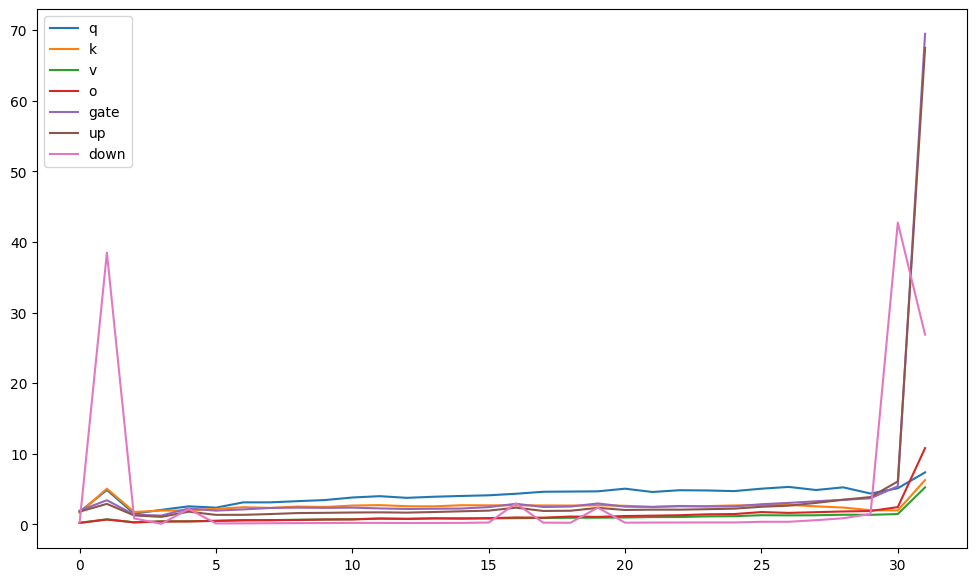

In [400]:
fig, ax = plt.subplots(figsize=(12,7))

# Loop through the dictionary and plot each line with a label
for key, values in deltas.items():
    ax.plot(values, label=key)

# Adding a legend to distinguish the lines
ax.legend()


### Loaded vs Saved Weights 

In [22]:
def create_quant_state(absmax, shape):
    quant_state = QuantState(absmax, dtype=torch.bfloat16)
    quant_state.shape = torch.Size(shape)
    quant_state.blocksize = 64
    quant_state.quant_type = "nf4"
    quant_state.code = quant_map
    return quant_state

In [65]:
# Sanity Check if weights are loaded correctly into vllm model.

for n, p in model.named_parameters():

    print("Cheking:", n)
    
    if 'qkv_proj' in n:
        if 'absmax' in n: continue
        
        # Loaded qkv
        qkv_weight = model.get_parameter(n)
        qkv_absmax = model.get_parameter(n.replace(".weight", ".absmax"))
        qkv_shape = [qkv_weight.shape[0], qkv_weight.shape[1] * 2]
        q_shape   = [qkv_weight.shape[0], qkv_weight.shape[1] * 2 // 3]
        
        absmax = qkv_absmax.contiguous().view(-1)
        quant_state = create_quant_state(absmax, qkv_shape)
        
        W_dq = bnb.functional.dequantize_4bit(qkv_weight.contiguous().view(-1,1), quant_state=quant_state)

        # Saved q proj
        q_proj_weight_name = n.replace("qkv_proj", "q_proj")
        q_proj_absmax_name = n.replace("qkv_proj", "q_proj").replace(".weight", ".absmax")
        
        absmax = quantized_state_dict[q_proj_absmax_name].cuda().contiguous().view(-1)
        quant_state = create_quant_state(absmax, q_shape)
        
        W_q_proj_dq = bnb.functional.dequantize_4bit(quantized_state_dict[q_proj_weight_name].contiguous().view(-1,1).cuda(), quant_state=quant_state)

        # Compare with HF model state dict
        param = Params4bit(hf_state_dict[q_proj_weight_name].t(), blocksize=64, compress_statistics=False, quant_type='nf4').cuda()
        W_q_proj_dq_hf = dequantize_4bit(param.data, param.quant_state)
        
        # Saved k proj
        k_proj_weight_name = n.replace("qkv_proj", "k_proj")
        k_proj_absmax_name = n.replace("qkv_proj", "k_proj").replace(".weight", ".absmax")
        
        absmax = quantized_state_dict[k_proj_absmax_name].cuda().contiguous().view(-1)
        quant_state = create_quant_state(absmax, q_shape)
        
        W_k_proj_dq = bnb.functional.dequantize_4bit(quantized_state_dict[k_proj_weight_name].contiguous().view(-1,1).cuda(), quant_state=quant_state)

        # Compare with HF model state dict
        param = Params4bit(hf_state_dict[k_proj_weight_name].t(), blocksize=64, compress_statistics=False, quant_type='nf4').cuda()
        W_k_proj_dq_hf = dequantize_4bit(param.data, param.quant_state)        

        # Saved v proj
        v_proj_weight_name = n.replace("qkv_proj", "v_proj")
        v_proj_absmax_name = n.replace("qkv_proj", "v_proj").replace(".weight", ".absmax")

        absmax = quantized_state_dict[v_proj_absmax_name].cuda().contiguous().view(-1)
        quant_state = create_quant_state(absmax, q_shape)

        W_v_proj_dq = bnb.functional.dequantize_4bit(quantized_state_dict[v_proj_weight_name].contiguous().view(-1,1).cuda(), quant_state=quant_state)

         # Compare with HF model state dict
        param = Params4bit(hf_state_dict[v_proj_weight_name].t(), blocksize=64, compress_statistics=False, quant_type='nf4').cuda()
        W_v_proj_dq_hf = dequantize_4bit(param.data, param.quant_state)       

        # Check whether loaded vs saved weights are equal after dequantization.
        assert torch.equal(W_dq, torch.cat([W_q_proj_dq, W_k_proj_dq, W_v_proj_dq], dim=1))

        assert torch.equal(W_dq, torch.cat([W_q_proj_dq_hf, W_k_proj_dq_hf, W_v_proj_dq_hf], dim=1))
    
    
    elif 'gate_up_proj' in n:
        if 'absmax' in n: continue
            
        # Loaded gate_up
        gate_up_weight = model.get_parameter(n)
        gate_up_absmax = model.get_parameter(n.replace(".weight", ".absmax"))
        gate_up_shape = [gate_up_weight.shape[0], gate_up_weight.shape[1] * 2]
        gate_shape    = [gate_up_weight.shape[0], gate_up_weight.shape[1] * 2 // 2]

        absmax = gate_up_absmax.contiguous().view(-1)
        quant_state = create_quant_state(absmax, gate_up_shape)
        
        W_dq = bnb.functional.dequantize_4bit(gate_up_weight.contiguous().view(-1,1), quant_state=quant_state)

        # Saved gate_proj
        gate_proj_weight_name = n.replace("gate_up_proj", "gate_proj")
        gate_proj_absmax_name = n.replace("gate_up_proj", "gate_proj").replace(".weight", ".absmax")
        
        absmax = quantized_state_dict[gate_proj_absmax_name].cuda().contiguous().view(-1)
        quant_state = create_quant_state(absmax, gate_shape)
        
        W_gate_proj_dq = bnb.functional.dequantize_4bit(quantized_state_dict[gate_proj_weight_name].contiguous().view(-1,1).cuda(), quant_state=quant_state)

        # Saved up_proj
        up_proj_weight_name = n.replace("gate_up_proj", "up_proj")
        up_proj_absmax_name = n.replace("gate_up_proj", "up_proj").replace(".weight", ".absmax")
        
        absmax = quantized_state_dict[up_proj_absmax_name].cuda().contiguous().view(-1)
        quant_state = create_quant_state(absmax, gate_shape)

        W_up_proj_dq = bnb.functional.dequantize_4bit(quantized_state_dict[up_proj_weight_name].contiguous().view(-1,1).cuda(), quant_state=quant_state)

        # Check whether loaded vs saved weights are equal after dequantization.
        assert torch.equal(W_dq, torch.cat([W_gate_proj_dq, W_up_proj_dq], dim=1))
    
    
    else:
        # Check whether loaded vs saved weights are equal after dequantization.
        assert torch.equal(quantized_state_dict[n].data, p.data.cpu())
        
        # Loaded gate_up
        if any(l in n for l in ["o_proj", "down_proj"]):
            if "weight" in n:
                weight = model.get_parameter(n)
                absmax = model.get_parameter(n.replace(".weight", ".absmax"))
                shape = [weight.shape[0], weight.shape[1] * 2]
                absmax = absmax.contiguous().view(-1)
                quant_state = create_quant_state(absmax, shape)
                W_dq = bnb.functional.dequantize_4bit(weight.contiguous().view(-1,1), quant_state=quant_state)

                # Compare with HF model state dict
                param = Params4bit(hf_state_dict[n].t(), blocksize=64, compress_statistics=False, quant_type='nf4').cuda()
                assert torch.equal(W_dq, dequantize_4bit(param.data, param.quant_state))
                
        else:
            # Compare with HF model state dict
            assert torch.equal(quantized_state_dict[n].data, hf_state_dict[n])

    
    if any(l in n for l in ["qkv_proj", "o_proj", "gate_up_proj", "down_proj"]) and "weight" in n:
        module = model.get_submodule(n.rpartition(".")[0])
        input_size = module.weight.shape[0]
        x = torch.randn(1,input_size).cuda().to(torch.bfloat16)
        out1 = module(x)
        if len(out1) > 1: out1 = out1[0]
        out2 = x @ W_dq
        
        # Check forward pass is correct.
        assert torch.equal(out1, out2)

    # print(p.view(-1)[:10])

Cheking: model.embed_tokens.weight
Cheking: model.layers.0.self_attn.qkv_proj.weight
Cheking: model.layers.0.self_attn.qkv_proj.absmax
Cheking: model.layers.0.self_attn.o_proj.weight
Cheking: model.layers.0.self_attn.o_proj.absmax
Cheking: model.layers.0.mlp.gate_up_proj.weight
Cheking: model.layers.0.mlp.gate_up_proj.absmax
Cheking: model.layers.0.mlp.down_proj.weight
Cheking: model.layers.0.mlp.down_proj.absmax
Cheking: model.layers.0.input_layernorm.weight
Cheking: model.layers.0.post_attention_layernorm.weight
Cheking: model.layers.1.self_attn.qkv_proj.weight
Cheking: model.layers.1.self_attn.qkv_proj.absmax
Cheking: model.layers.1.self_attn.o_proj.weight
Cheking: model.layers.1.self_attn.o_proj.absmax
Cheking: model.layers.1.mlp.gate_up_proj.weight
Cheking: model.layers.1.mlp.gate_up_proj.absmax
Cheking: model.layers.1.mlp.down_proj.weight
Cheking: model.layers.1.mlp.down_proj.absmax
Cheking: model.layers.1.input_layernorm.weight
Cheking: model.layers.1.post_attention_layernorm.we

In [66]:
# TODO: Check activations VLLM bnb vs HF bnb